# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import qnm
from gwpy.timeseries import TimeSeries
import copy
from scipy.special import logsumexp
import astropy.constants as c

## Data

In [3]:
theoretical_values = [50, 0.69]

In [4]:
omega, A, C = qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=theoretical_values[1])
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

(0.245, 0.265)

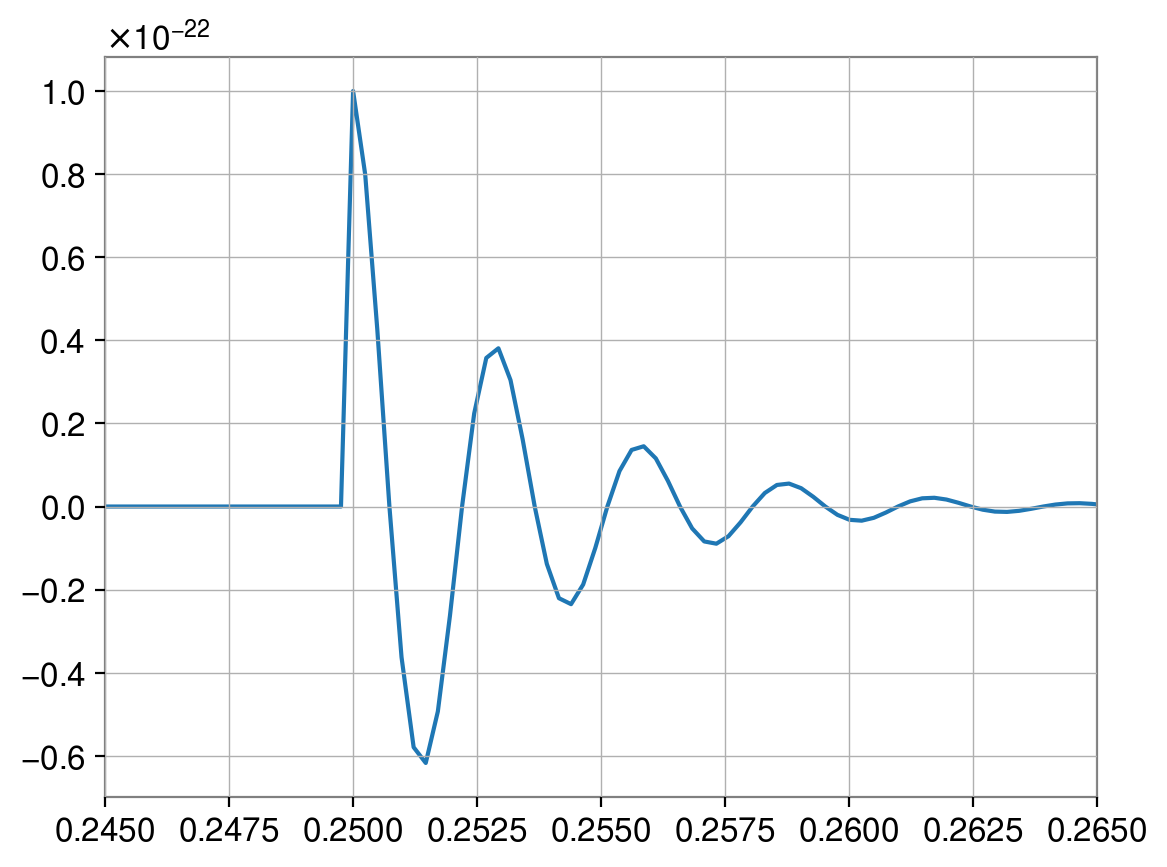

In [5]:
srate = 4096
t_range_prepad = np.linspace(0,0.5, int(srate/2), endpoint = False)
heaviside = np.heaviside(t_range_prepad, 1)
temp = 1e-22*np.exp(-1j*omega*t_range_prepad/(theoretical_values[0]*T_MSUN))
signal_prepad = np.real(temp*heaviside)
t_range = np.linspace(0,1, srate, endpoint = False)
signal = np.pad(signal_prepad, (int(srate/4),int(srate/4)))
noise = 0

data = signal + noise
pl.plot(t_range, data)
pl.xlim(0.245, 0.265)

## Filter

In [6]:
input = dict(model_list = [(2,2,0, 'p')], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 0.25, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [7]:
fit.original_data['H1'] = qnm_filter.RealData(data, index = t_range)

In [8]:
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.compute_acfs('original_data')

In [9]:
temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 1*1e-24**2
fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()

In [10]:
fit.first_index()
template = fit.truncate_data(fit.original_data)['H1']

In [11]:
fit.compute_SNR(0, template, 'H1', optimal=True)

191.89602041918647

In [12]:
delta_mass = 2.0
delta_chi = 0.05
massspace = np.arange(20, 80, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [20]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [15]:
fit.compute_likelihood(apply_filter = False)

-18412.041326360417

In [16]:
fit.add_filter(mass = 50, chi = 0.5, model_list = [(2,2,0,'p')])
fit.compute_likelihood()

-1944.805727183552

In [17]:
fit.compute_likelihood() / fit.compute_likelihood(apply_filter=False)

0.10562683912723923

In [18]:
bayes_arr = []
acf_arr = [1*1e-23**2, 3*1e-23**2, 1*1e-22**2]
SNR_arr = []

for i in acf_arr:
    temp_acf[0] = 1*i
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()
    template = fit.truncate_data(fit.original_data)['H1']
    SNR_arr.append(fit.compute_SNR(0, template, 'H1', optimal=True))
    
    temp0 = fit.compute_likelihood(apply_filter = False)
    fit.add_filter(mass = 50, chi = 0.5, model_list = [(2,2,0,'p')])
    temp1 = fit.compute_likelihood()
    bayes_arr.append(temp1 / temp0)

In [19]:
bayes_arr

[0.10562683912723925, 0.10562683912723927, 0.10562683912723923]

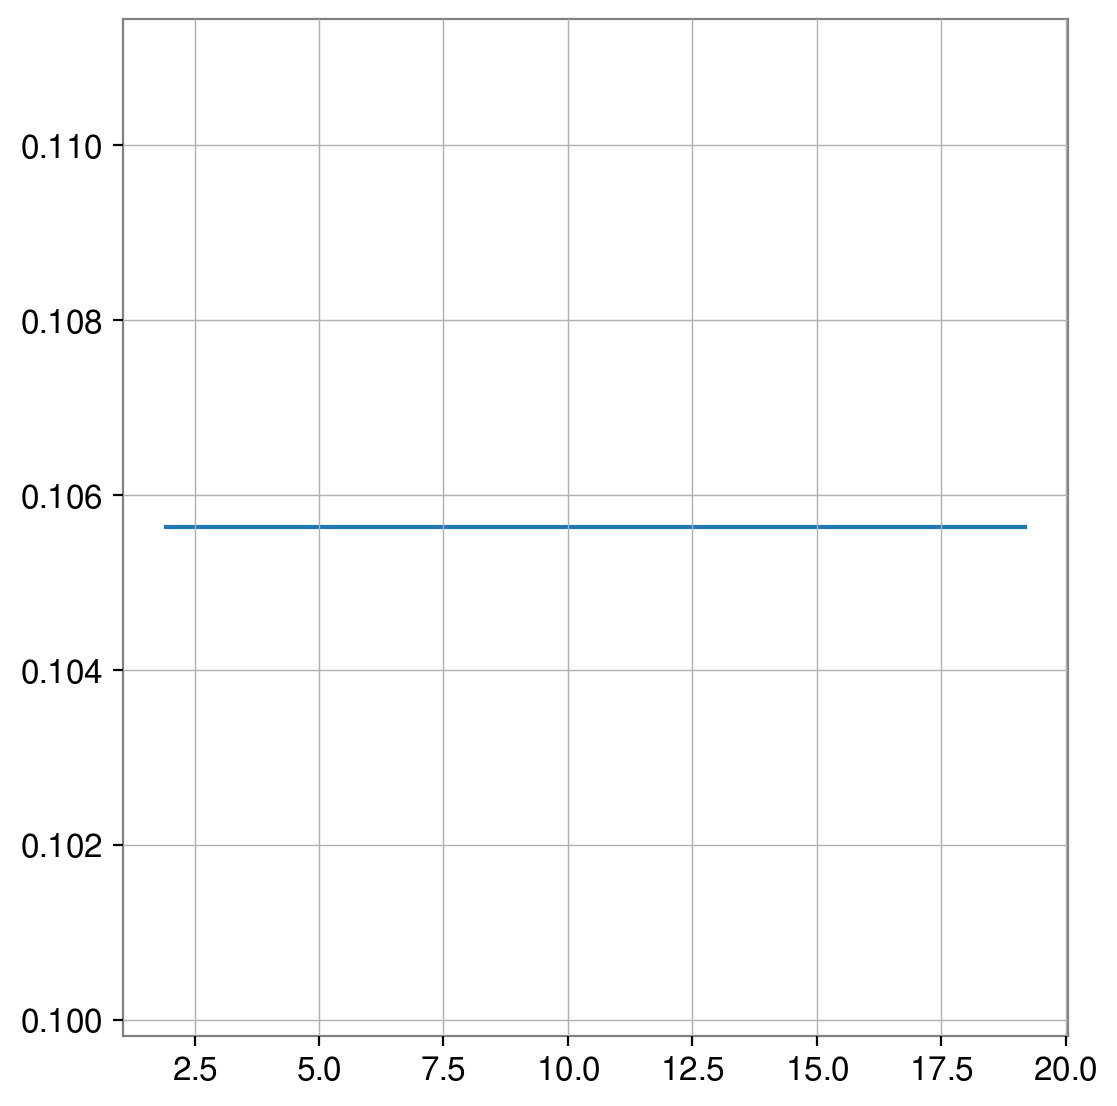

In [77]:
pl.plot(SNR_arr, bayes_arr)

In [60]:
credible_region = qnm_filter.find_credible_region(likelihood_data, target_probability=0.9)

Text(60, 0.1, 'ln(evidence) = 5.67')

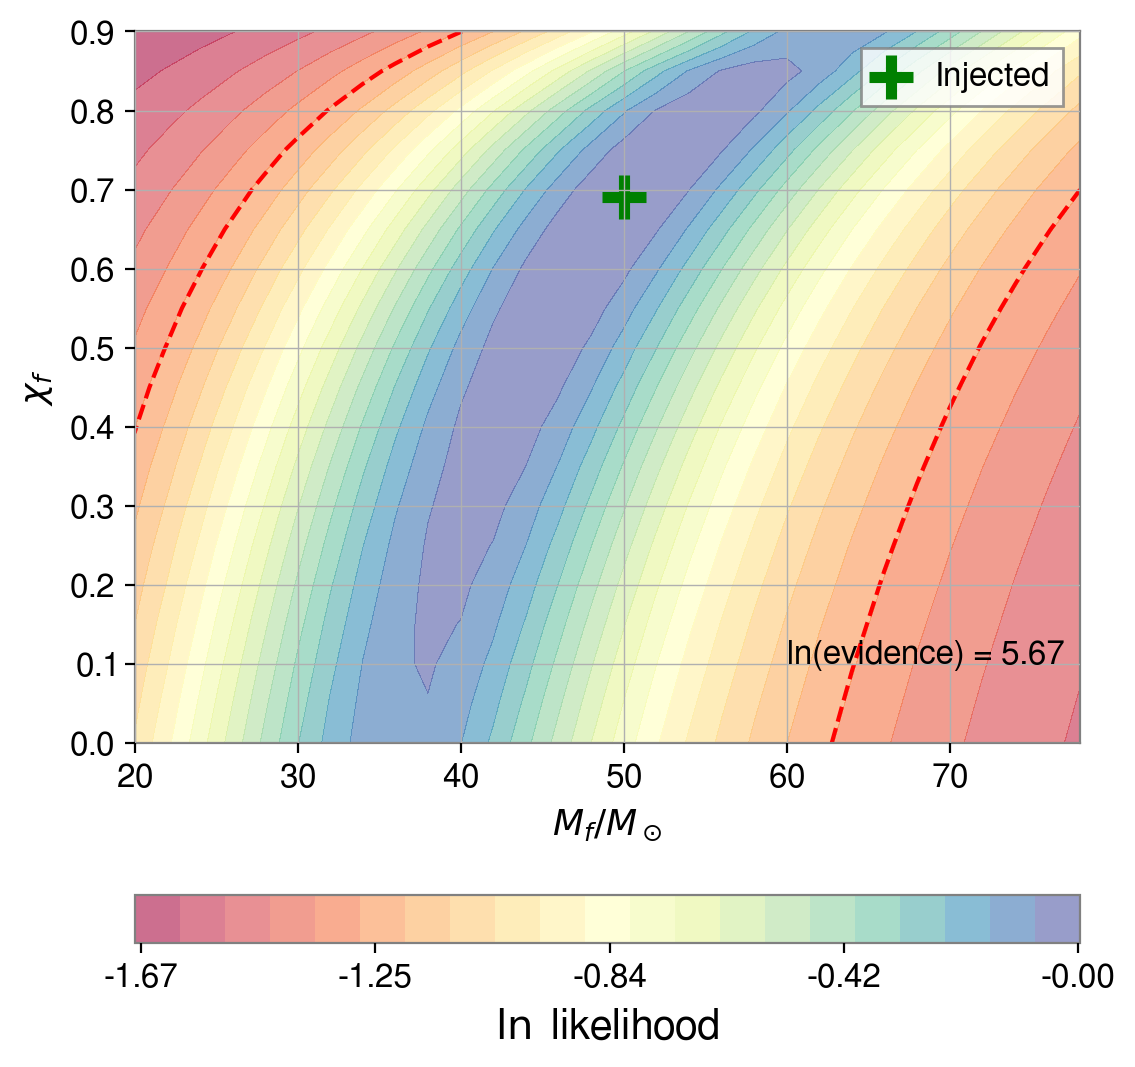

In [21]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=theoretical_values[0], y=theoretical_values[1], s=255, marker='+', 
           c='g', linewidths=4, label='Injected')
# ax.scatter(x=average_mass, y=average_chi, s=255, marker='+', 
#            c='r', linewidths=4, label='weighted average')
# ax.scatter(x=MAP_value[0], y=MAP_value[1], s=255, marker='+', 
#            c='y', linewidths=4, label='MAP')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend()
# ax.set_title("Filters: " + filters_str + "     t = " + time_str + r'$M_f$')
ax.text(60, 0.1, 'ln(evidence) = %.2f' % (logsumexp(likelihood_data)))
# ax.text(118, 0.1, '$\epsilon_{MAP} = %.2f$' '\n' '$\epsilon_{avg} = %.2f$' % (MAP_epsilon, average_epsilon))